In [18]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
import copy

from scipy.spatial.distance import cdist

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.filterwarnings('ignore')

from utils import *

from sklearn.metrics import f1_score

import pickle

In [2]:
## read data as a dictionary with each subject as a different key
## the sessions are included as a column in each dataframe
pathData = Path(r'./TrainingData')
dctData = read_data(pathData)

In [3]:
## upsample labels using nearest neighbor
dctUps = upsampleData(dctData)

In [4]:
## count number of timesteps for each session and subject
dctClass = {f'subject_{k+1}':pd.DataFrame(index = range(1, 9), columns = range(0, 4), data = 0) for k in range(8)}
for k in dctUps.keys():
    dfs = dctUps[k]
    for s in dfs['session'].unique():
        dfss = dfs[dfs['session'] == s]
        aux = dfss['class'].value_counts().sort_index()
        dctClass[k].loc[s, aux.index] = aux.values

In [5]:
## get the number of instances for each to make the dataset balanced
## the first and second more frequents per session and individual are set to two times
## the third class in case they are larger. The mode is set as the same of the second 
## more repeated class
dctClassBal = balanceData(dctClass, 2)

In [6]:
## randomly select values for the 2 mode classes to match the dctClassBal
dctUpsBal = {}
for k in dctUps.keys():
    dfk =  dctUps[k]
    out2 = []
    for s in dfk['session'].unique():
        dfks = dfk[dfk['session'] == s]

        nvalAll = dctClass[k].loc[s, :]
        nvalBall = dctClassBal[k].loc[s, :]
        
        out = []
        for c in nvalAll.index:
            dfksc = dfks[dfks['class'] == c]
            dfkscBal = dfks.sample(nvalBall.loc[c]).sort_index()
            out.append(dfkscBal)
        dfout = pd.concat(out).sort_index()
        out2.append(dfout)
    dctUpsBal[k] = pd.concat(out2)

In [23]:
with open('balancedDataset.pkl', 'wb') as fout:
    pickle.dump(dctUpsBal, fout)

In [7]:
cols = ['accx', 'accy', 'accz', 'gyrox', 'gyroy', 'gyroz', 'class']
dfX, dfy = [], []
for k in dctUpsBal.keys():
    dfk = dctUpsBal[k].loc[:, cols]
    dfk['subject'] = [k]*len(dfk)
    dfy.append(dfk.loc[:, 'class'].values)
    dfk = dfk.drop(['class'], axis = 1)
    dfX.append(dfk.values)
dfX = pd.DataFrame(columns = dfk.columns, data = np.concatenate(dfX, axis = 0))
dfy = pd.DataFrame(columns = ['class'], data = np.concatenate(dfy, axis = 0))

In [8]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()    
    self.cnn1 = nn.Conv1d(6, 24, 9, stride = 1, padding = 4)
    self.bn1 = nn.BatchNorm1d(num_features = 24)
    self.avPool1 = nn.AvgPool1d(5, stride = 1, padding = 2)

    self.cnn2 = nn.Conv1d(24, 48, 7, stride = 1, padding = 3)
    self.bn2 = nn.BatchNorm1d(num_features = 48)
    self.avPool2 = nn.AvgPool1d(3, stride = 1, padding = 1)
    
    self.lin1 = nn.Linear(in_features = 1200, out_features = 600)
    self.bn3 = nn.BatchNorm1d(num_features = 600)
    self.lin2 = nn.Linear(in_features = 600, out_features = 200)
    self.bn4 = nn.BatchNorm1d(num_features = 200)
    self.lin3 = nn.Linear(in_features = 200, out_features = 100)
    self.bn5 = nn.BatchNorm1d(num_features = 100)
    self.lin4 = nn.Linear(in_features = 100, out_features = 40)
    self.bn6 = nn.BatchNorm1d(num_features = 40)
    self.lin5 = nn.Linear(in_features = 40, out_features = 4)

    self.dout = nn.Dropout(p=0.4)

  def forward(self, x):
    x = self.cnn1(x)
    # print(f'cnn 1: {x.shape}')
    x = self.bn1(x)
    # print(f'bn 1: {x.shape}')
    x = F.relu(x)
    x = self.avPool1(x)
    # print(f'av pool 1: {x.shape}')

    x = self.cnn2(x)
    # print(f'cnn 2: {x.shape}')
    x = self.bn2(x)
    # print(f'bn 1: {x.shape}')
    x = F.relu(x)
    x = self.avPool2(x)
    # print(f'av pool 2: {x.shape}')

    x = x.flatten(start_dim = 1)
    # print(f'shape after flatten: {x.shape}')
    
    x = self.lin1(x)
    x = F.relu(x)
    x = self.bn3(x)
    x = self.dout(x)

    x = self.lin2(x)
    x = F.relu(x)
    x = self.bn4(x)
    x = self.dout(x)

    x = self.lin3(x)
    x = F.relu(x)
    x = self.bn5(x)
    x = self.dout(x)

    x = self.lin4(x)
    x = F.relu(x)
    x = self.bn6(x)
    x = self.dout(x)

    x = self.lin5(x)
    x = F.softmax(x, dim = 1)

    return x

In [9]:
# Creating a wrapper so we have the same interface for all the methods
class NetWrapper:
  def __init__(self, epochs, lrate, dev, w):
    self.model = Net()
    if w != None:
      self.loss = nn.CrossEntropyLoss(w)
    else:
      self.loss = nn.CrossEntropyLoss()
      
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lrate)
    self.device = dev
    self.model.to(self.device)
    self.epochs = epochs
    self.history = {'train_loss': [], 'val_loss': [],
                    'train_accuracy': [], 'val_accuracy': []}
    self.accuracy = []
    self.min_loss = np.inf
    self.best_weights = None

  def accuracyFx(self, predVals, trueVals):
    predVals = predVals.cpu().detach().numpy()
    trueVals = trueVals.cpu().detach().numpy()
    correct = np.sum(np.array(predVals == trueVals)).item()
    total = trueVals.shape[0]
    accuracy = 100 * correct / total
    return accuracy

  def fit(self, tloader, vloader):
    
    for t in range(self.epochs):

        ########### Training
        self.model.train()
        self.optimizer.zero_grad()

        lossL, accL = [], []
        for b, (Xtrb, ytrb) in enumerate(tloader):
          Xtrb = Xtrb.permute(0, 2, 1).to(self.device)
          ytrb = ytrb.squeeze(2)
          ytrb, _ = torch.mode(ytrb, dim = 1)
          ytrb = ytrb.to(self.device)
          # print(f'ytrb shape: {ytrb.shape}')
          yPred = self.model(Xtrb)
          ## compute loss
          loss = self.loss(yPred, ytrb)
          loss_val = float(loss.cpu().detach().numpy())
          # print(loss_val)
          ## compute accuracy
          acc_val = self.accuracyFx(yPred, ytrb)
          ## backward propagation
          loss.backward()
          self.optimizer.step()
          lossL.append(loss_val)
          accL.append(acc_val)

        self.history[r'train_loss'].append(np.mean(lossL))
        self.history[r'train_accuracy'].append(np.mean(accL))
          
        ########### Evaluation
        self.model.eval()
        lossL, accL = [], []
        for b, (Xvalb, yvalb) in enumerate(vloader):
          Xvalb = Xvalb.permute(0, 2, 1).to(self.device)
          yvalb = yvalb.squeeze(2)
          yvalb, _ = torch.mode(yvalb, dim = 1)
          yvalb = yvalb.to(self.device)
          yPred = self.model(Xvalb)
          ## compute loss
          loss = self.loss(yPred, yvalb)
          loss_val = float(loss.cpu().detach().numpy())
          ## compute accuracy
          acc_val = self.accuracyFx(yPred, yvalb)
          lossL.append(loss_val)
          accL.append(acc_val)

        self.history[r'val_loss'].append(np.mean(lossL))
        self.history[r'val_accuracy'].append(np.mean(accL))

        if loss < self.min_loss:
          self.min_loss = loss
          self.best_weights = copy.deepcopy(self.model.state_dict())

        if t%100 == 0:
          a = self.history[f'train_loss'][t]
          b = self.history[f'val_loss'][t]
          c = self.history[f'train_accuracy'][t]
          d = self.history[f'val_accuracy'][t]
        
          print(f'Epoch {t}/{self.epochs}. Training loss: {a:0.3f} - Validation loss: {b:0.3f} Training accuracy: {c:0.3f} - Validation accuracy: {d:0.3f}')
    
    dfhist = pd.DataFrame.from_dict(self.history)

    return dfhist, self.min_loss, self.best_weights

  def predict(self, X):
    X = X.permute(0, 2, 1)
    X = X.to(self.device)
    pred = self.model(X)
    pred = pred.cpu().detach().numpy()

    return pred

Epoch 0/2000. Training loss: 1.399 - Validation loss: 1.392 Training accuracy: 0.000 - Validation accuracy: 0.000
Epoch 100/2000. Training loss: 1.110 - Validation loss: 1.189 Training accuracy: 0.000 - Validation accuracy: 0.000
Epoch 200/2000. Training loss: 0.984 - Validation loss: 1.097 Training accuracy: 0.000 - Validation accuracy: 0.000
Epoch 300/2000. Training loss: 0.911 - Validation loss: 1.084 Training accuracy: 0.000 - Validation accuracy: 0.000
Epoch 400/2000. Training loss: 0.863 - Validation loss: 1.069 Training accuracy: 0.000 - Validation accuracy: 0.000
Epoch 500/2000. Training loss: 0.833 - Validation loss: 1.068 Training accuracy: 0.000 - Validation accuracy: 0.000
Epoch 600/2000. Training loss: 0.813 - Validation loss: 1.069 Training accuracy: 0.000 - Validation accuracy: 0.000
Epoch 700/2000. Training loss: 0.799 - Validation loss: 1.066 Training accuracy: 0.000 - Validation accuracy: 0.000
Epoch 800/2000. Training loss: 0.790 - Validation loss: 1.063 Training acc

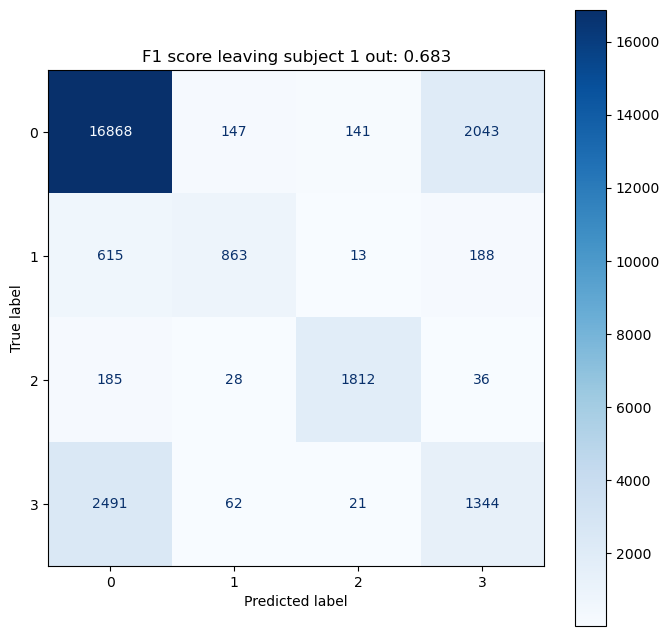

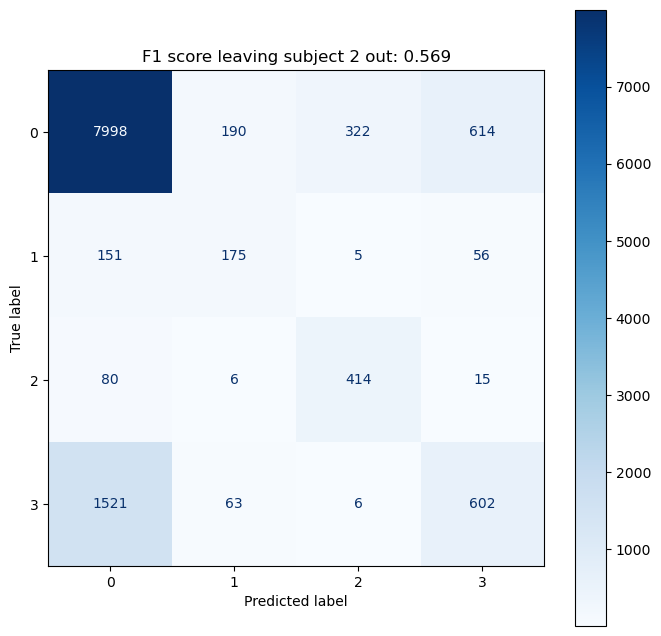

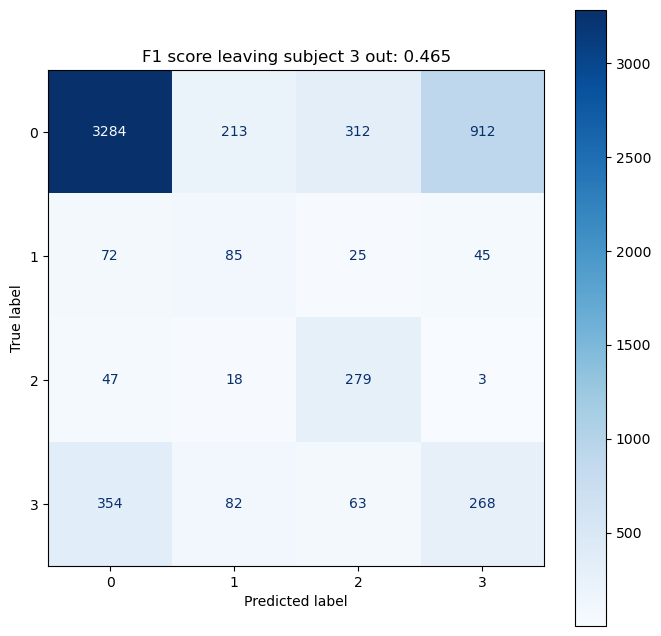

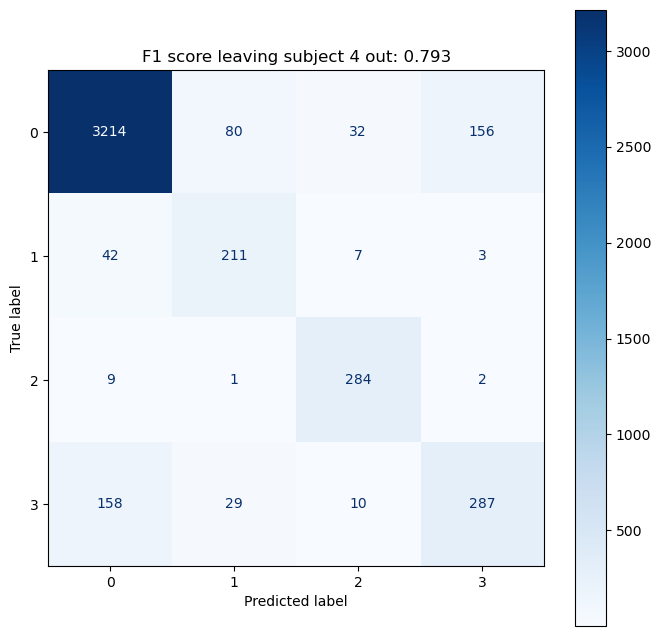

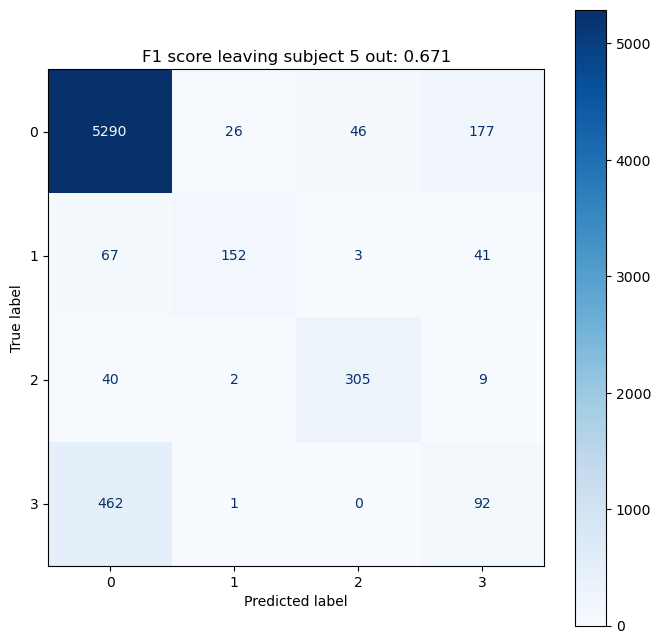

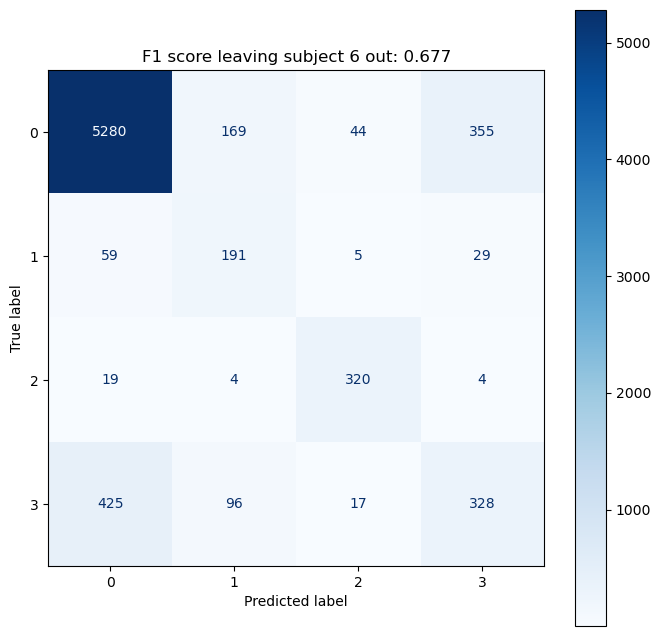

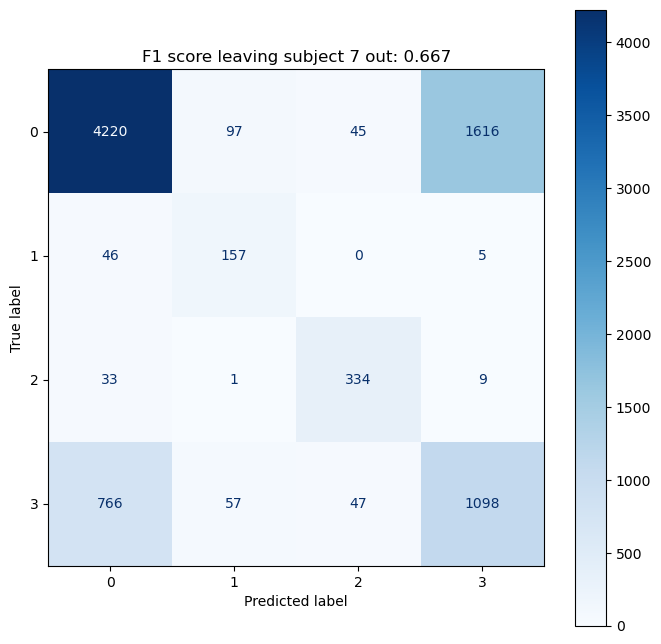

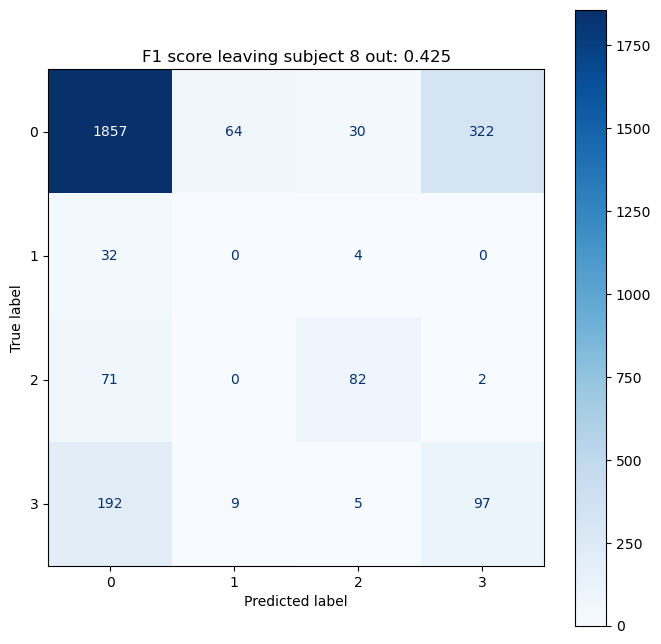

In [17]:
for kVal in [f'subject_{i}' for i in range(1,9)]:

    dfXtr = dfX[dfX['subject'] != kVal]
    dfytr = dfy.loc[dfXtr.index, :]

    dfXvl = dfX[dfX['subject'] == kVal]
    dfyvl = dfy.loc[dfXvl.index, :]

    scaler = StandardScaler()
    Xtr_sc = scaler.fit_transform(dfXtr.iloc[:, :-1])
    Xvl_sc = scaler.transform(dfXvl.iloc[:, :-1])

    Xtr = torch.tensor(Xtr_sc.astype('float32'))
    ytr = torch.tensor(dfytr.values.astype('int64'))

    Xvl = torch.tensor(Xvl_sc.astype('float32'))
    yvl = torch.tensor(dfyvl.values.astype('int64'))

    seq_len = 25 # length of each sequence
    overlap = 5 # overlapping between sequences
    tr_sequences = []
    vl_sequences = []

    # create sequences for training data
    for i in range(0, len(Xtr)-seq_len, overlap):
        seq_X = Xtr[i:i+seq_len]
        seq_y = ytr[i:i+seq_len]
        tr_sequences.append((seq_X, seq_y))

    # create sequences for validation data
    for i in range(0, len(Xvl)-seq_len, overlap):
        seq_X = Xvl[i:i+seq_len]
        seq_y = yvl[i:i+seq_len]
        vl_sequences.append((seq_X, seq_y))

    bsize = 25_000
    trLoader = DataLoader(tr_sequences, batch_size = bsize, shuffle = False)
    vlLoader = DataLoader(vl_sequences, batch_size = bsize, shuffle = False)

    torch.cuda.empty_cache()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    learning_rate = 1e-4

    net = NetWrapper(2_000, learning_rate, device, None)
    dfhist, minLoss, bestModel = net.fit(trLoader, vlLoader)

    preds = []
    trues = []
    for b, (Xvalb, yvalb) in enumerate(vlLoader):
        preds.extend(net.predict(Xvalb).argmax(axis = 1))
        yvalb = yvalb.squeeze(2)
        yvalb, _ = torch.mode(yvalb, dim = 1)
        trues.extend(yvalb.detach().numpy())

    m = confusion_matrix(trues, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=m)
    fig, ax = plt.subplots(figsize = (8, 8))
    disp.plot(ax = ax,  cmap = plt.cm.Blues)
    ax.set_title(f"F1 score leaving subject {kVal.split('_')[1]} out: {f1_score(preds, trues, average='macro'):0.3f}")

Ensemble the models in case we decide to go with this

In [12]:
# def ensemble_predict(inputs):
#     outputs = []
#     with torch.no_grad():
#         # get the predictions of each individual model
#         outputs.append(model1(inputs))
#         outputs.append(model2(inputs))
#         outputs.append(model3(inputs))
#         outputs.append(model4(inputs))
#         outputs.append(model5(inputs))
#         outputs.append(model6(inputs))
#         outputs.append(model7(inputs))
#         outputs.append(model8(inputs))
        
#         # take the average of the outputs
#         outputs = torch.stack(outputs).mean(dim=0)
        
#         # return the class with the highest probability
#         _, predicted = torch.max(outputs, 1)
#     return predicted
